# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

## Part 1: Preprocessing¶

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding.

In [2]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [4]:
test.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,114835,7 - ELEVEN,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,"{'longitude': '-87.62935653990546', 'latitude'...",0
1,1575555,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'...",0
2,671061,TROTTER'S TO GO,TROTTER'S TO GO,1092634.0,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,CHICAGO,IL,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,"{'longitude': '-87.66204067083224', 'latitude'...",0
3,1965844,BIG G'S PIZZA,BIG G'S PIZZA,2334691.0,Restaurant,Risk 1 (High),1132 W TAYLOR ST,CHICAGO,IL,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,"{'longitude': '-87.65550098867566', 'latitude'...",1
4,1751669,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,3491970.0,School,Risk 2 (Medium),1021 E 83RD,CHICAGO,IL,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,"{'longitude': '-87.59929083361996', 'latitude'...",1


### Concatenate the training and testing sets to easy data manipulation

In [93]:
df_main = pd.concat([train,test])

In [43]:
df_main.shape

(69222, 17)

In [17]:
# the orignial shapes of the files
"train 51916 test 17306: " + str(51916 + 17306)

'train 51916 test 17306: 69222'

In [18]:
# lot's of NaNs in different columns
df_main.isna().sum()

Inspection ID          0
DBA Name               0
AKA Name             845
License #              7
Facility Type        311
Risk                  19
Address                0
City                  71
State                 12
Zip                   34
Inspection Date        0
Inspection Type        1
Violations         12935
Latitude             259
Longitude            259
Location             259
Fail                   0
dtype: int64

In [32]:
df_main.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [94]:
## Let's delete the columns with the same/redundant info
df_select_cols = df_main.drop(columns=['DBA Name','Address', 'City', 'State','Location'])

In [45]:
df_select_cols.shape

(69222, 12)

In [46]:
df_select_cols.isna().sum()

Inspection ID          0
AKA Name             845
License #              7
Facility Type        311
Risk                  19
Zip                   34
Inspection Date        0
Inspection Type        1
Violations         12935
Latitude             259
Longitude            259
Fail                   0
dtype: int64

In [47]:
#check the data type 
df_select_cols.dtypes

Inspection ID        int64
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Fail                 int64
dtype: object

In [95]:
df_select_cols.head()

,Inspection ID,AKA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Fail
0,2088270,TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,1
1,555268,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,0
2,1751394,A P DELI,47405.0,Restaurant,Risk 1 (High),60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,0
4,453326,MORRILL,24571.0,School,Risk 1 (High),60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,0


## Import Columns: let's take care of the strings
## Not Hot encoding these two columns

In [96]:
#let's split the string so that we keep only the violation number
df_select_cols['Violations_int'] = df_select_cols['Violations'].str.split('.').str[0]

In [99]:
#let's extract the digits representing the risk category
df_select_cols['risk_int'] = df_select_cols['Risk'].str.extract('(\d+)', expand=False)

In [101]:
#delete the orignal columns
df_select_cols = df_select_cols.drop(columns=['Violations', 'Risk'])

In [102]:
df_select_cols.head()

,Inspection ID,AKA Name,License #,Facility Type,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Fail,Violations_int,risk_int
0,2088270,TOM YUM CAFE,2354911.0,Restaurant,60657.0,2017-09-15T00:00:00,Canvass,41.938007,-87.644755,1,3,1
1,555268,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,41.772402,-87.683603,0,32,3
2,1751394,A P DELI,47405.0,Restaurant,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,41.758779,-87.575054,0,35,1
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,60632.0,2016-04-29T00:00:00,Canvass,41.812181,-87.707125,0,38,2
4,453326,MORRILL,24571.0,School,60629.0,2011-01-10T00:00:00,Canvass,NaN,NaN,0,34,1


In [103]:
df_select_cols.isna().sum()

Inspection ID          0
AKA Name             845
License #              7
Facility Type        311
Zip                   34
Inspection Date        0
Inspection Type        1
Latitude             259
Longitude            259
Fail                   0
Violations_int     12935
risk_int              19
dtype: int64

In [104]:
df_select_cols.dtypes

Inspection ID        int64
AKA Name            object
License #          float64
Facility Type       object
Zip                float64
Inspection Date     object
Inspection Type     object
Latitude           float64
Longitude          float64
Fail                 int64
Violations_int      object
risk_int            object
dtype: object

### filling all the int columsn with mean values

In [105]:
def mean_fill_na(X):
    for col in X:
        if X[col].dtypes == int or X[col].dtypes ==float:
            if X[col].isnull().sum()>0:
                X[col]=X[col].fillna(X[col].mean())
            
    return X

In [106]:
mean_fill_na(df_select_cols)

,Inspection ID,AKA Name,License #,Facility Type,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Fail,Violations_int,risk_int
0,2088270,TOM YUM CAFE,2354911.0,Restaurant,60657.0,2017-09-15T00:00:00,Canvass,41.938007,-87.644755,1,3,1
1,555268,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,41.772402,-87.683603,0,32,3
2,1751394,A P DELI,47405.0,Restaurant,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,41.758779,-87.575054,0,35,1
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,60632.0,2016-04-29T00:00:00,Canvass,41.812181,-87.707125,0,38,2
4,453326,MORRILL,24571.0,School,60629.0,2011-01-10T00:00:00,Canvass,41.879555,-87.676658,0,34,1
5,1725221,LAKEVIEW REHABILITATION AND NURSING CENTER,2245580.0,Long Term Care,60614.0,2016-02-22T00:00:00,Canvass,41.932632,-87.647973,0,31,1
6,1981372,GOLD COAST DOGS,32318.0,Restaurant,60606.0,2017-01-12T00:00:00,Canvass,41.878531,-87.639427,0,30,2
7,1072403,NaN,2241028.0,Restaurant,60620.0,2013-05-07T00:00:00,License Re-Inspection,41.735505,-87.643749,0,38,1
8,1464616,THE PUMPING CO,1544937.0,Restaurant,60660.0,2014-11-28T00:00:00,Canvass,41.993973,-87.660242,1,16,1
9,583261,YUMMY YUMMY NOODLES,2098003.0,Restaurant,60616.0,2011-06-01T00:00:00,License,41.855282,-87.631993,1,18,1


In [107]:
df_select_cols.isna().sum()

Inspection ID          0
AKA Name             845
License #              0
Facility Type        311
Zip                    0
Inspection Date        0
Inspection Type        1
Latitude               0
Longitude              0
Fail                   0
Violations_int     12935
risk_int              19
dtype: int64

### Categorical Columns: Let's fill them with mode

In [108]:
# all categorical columns can be filled with mode
df_no_nans = df_select_cols.fillna(df_select_cols.mode().iloc[0])

In [109]:
df_no_nans.isna().sum()

Inspection ID      0
AKA Name           0
License #          0
Facility Type      0
Zip                0
Inspection Date    0
Inspection Type    0
Latitude           0
Longitude          0
Fail               0
Violations_int     0
risk_int           0
dtype: int64

In [110]:
#I like keeping a copy of hte cleaned df before converting
#it through any dummy converter
df = df_no_nans.copy()

In [111]:
df.head()

,Inspection ID,AKA Name,License #,Facility Type,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Fail,Violations_int,risk_int
0,2088270,TOM YUM CAFE,2354911.0,Restaurant,60657.0,2017-09-15T00:00:00,Canvass,41.938007,-87.644755,1,3,1
1,555268,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,41.772402,-87.683603,0,32,3
2,1751394,A P DELI,47405.0,Restaurant,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,41.758779,-87.575054,0,35,1
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,60632.0,2016-04-29T00:00:00,Canvass,41.812181,-87.707125,0,38,2
4,453326,MORRILL,24571.0,School,60629.0,2011-01-10T00:00:00,Canvass,41.879555,-87.676658,0,34,1


###  Sklearn Label encoder for the catergoies not so important

In [112]:
from sklearn.preprocessing import LabelEncoder
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df

In [113]:
dummyEncode(df_no_nans)

,Inspection ID,AKA Name,License #,Facility Type,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Fail,Violations_int,risk_int
0,2088270,16591,2354911.0,282,60657.0,1910,7,41.938007,-87.644755,1,22,0
1,555268,5659,1044901.0,165,60636.0,458,10,41.772402,-87.683603,0,25,2
2,1751394,336,47405.0,282,60649.0,1552,8,41.758779,-87.575054,0,28,0
3,1763905,5923,6414.0,282,60632.0,1570,7,41.812181,-87.707125,0,31,1
4,453326,10909,24571.0,299,60629.0,261,7,41.879555,-87.676658,0,27,0
5,1725221,9171,2245580.0,202,60614.0,1523,7,41.932632,-87.647973,0,24,0
6,1981372,6380,32318.0,282,60606.0,1740,7,41.878531,-87.639427,0,23,1
7,1072403,14951,2241028.0,282,60620.0,837,22,41.735505,-87.643749,0,31,0
8,1464616,16339,1544937.0,282,60660.0,1224,7,41.993973,-87.660242,1,7,0
9,583261,17876,2098003.0,282,60616.0,360,21,41.855282,-87.631993,1,9,0


## Part 2: Modeling
Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

To earn a score of 3 for this part, get an ROC AUC test score >= 0.70.

### Spliting training and test df back into original shape

In [129]:
df_X = df_no_nans[:-17306]
df_X_test = df_no_nans[-17306:]

In [134]:
X = df_X.drop(columns=['Fail'])
y = df_X['Fail']

In [135]:
X_test = df_X_test.drop(columns=['Fail'])
y_test = df_X_test['Fail']

In [136]:
X.shape, y.shape, X_test.shape, y_test.shape

((51916, 11), (51916,), (17306, 11), (17306,))

In [166]:
y.shape

(51916,)

## Random Forest: choosing parameters and cross-validation scores

In [167]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline

X = df_X.drop(columns=['Fail'])
y = df_X['Fail']

pipe = make_pipeline(RandomForestClassifier(n_estimators=100, 
                            class_weight='balanced', 
                            min_samples_leaf=0.005, 
                            oob_score=True, n_jobs=-1)
                    )

cross_val_score(pipe, X, y, cv=5, scoring='roc_auc', verbose=10)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................ , score=0.988320911698835, total=   4.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] ....................... , score=0.9874640587194525, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV] ....................... , score=0.9872497294274118, total=   2.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s


[CV] ........................ , score=0.985685681980809, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.8s remaining:    0.0s


[CV] ....................... , score=0.9862231017948021, total=   1.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s finished


array([0.98832091, 0.98746406, 0.98724973, 0.98568568, 0.9862231 ])

### Model Fitting and ROC AUC

In [171]:
 pipe.fit(X, y)
y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
print('ROC AUC, OOB:', roc_auc_score(y, y_pred_proba))

ROC AUC, OOB: 0.9863221615230112


In [161]:
y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
print('ROC AUC, Out-of-Bag estimate:', roc_auc_score(y, y_pred_proba))

ROC AUC, Out-of-Bag estimate: 0.9864912494174838


### Predicting y probabilities using test data

In [186]:
y_pred = pipe.predict_proba(X_test)[:,1]

In [187]:
y_pred

array([0.09493944, 0.05253873, 0.0885198 , ..., 0.30332782, 0.17279639,
       0.15673198])

In [188]:
print('Validation ROC AUC:', roc_auc_score(y_test, y_pred))

Validation ROC AUC: 0.9864170094337693


### Just wanted to check the class prediction and classification report

In [181]:
y_prediction = pipe.predict(X_test)

In [183]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     12831
           1       0.94      0.91      0.92      4475

   micro avg       0.96      0.96      0.96     17306
   macro avg       0.95      0.94      0.95     17306
weighted avg       0.96      0.96      0.96     17306



### Gradient Boosting Classifier

In [191]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X)
X_test = encoder.transform(X_test)
gb = GradientBoostingClassifier()
gb.fit(X, y)
y_pred_proba = gb.predict_proba(X_test)[:,1]
print('Validation ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Validation ROC AUC: 0.9898592662933565
CPU times: user 5 s, sys: 40 ms, total: 5.04 s
Wall time: 4.46 s


## Part 3: Visualization
Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

Feature Importances
Permutation Importances
Partial Dependence Plot
To earn a score of 3 for this part, make at least two of these visualization types.

## Show feature importance

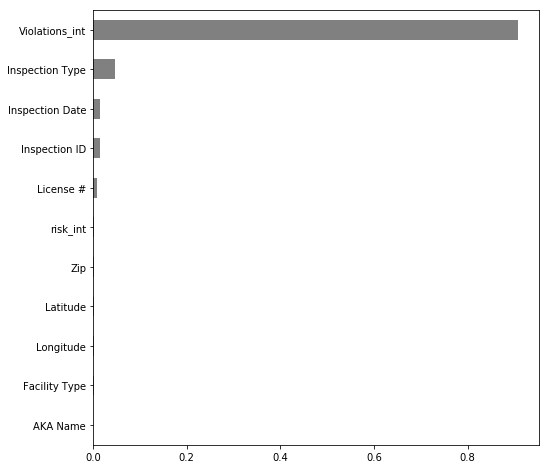

In [142]:
import matplotlib.pyplot as plt
def show_feature_importance(
pipe, X, y, estimator_name='randomforestclassifier',
n=20, figsize=(8,8)):
    
    #pipe must not change dimensions of X dataframe
    pipe.fit(X,y)
    
    importances = pd.Series(
    pipe.named_steps[estimator_name].feature_importances_,
    X.columns)
    
    top_n = importances.sort_values(ascending=False)[:n]
    
    plt.figure(figsize=figsize)
    top_n.sort_values().plot.barh(color='grey')


show_feature_importance(pipe, X, y)

In [144]:
!pip install eli5

  Using cached https://files.pythonhosted.org/packages/8d/c8/04bed18dcce1d927b0dd5fc3425777354b714d2e62d60ae301928b5a5bf8/eli5-0.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c2/fd/202954b3f0eb896c53b7b6f07390851b1fd2ca84aa95880d7ae4f434c4ac/tabulate-0.8.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/4a/bd/eee1157fc2d8514970b345d69cb9975dcd1e42cd7e61146ed841f6e68309/typing-3.6.6-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1f/e2/ef2581b5b86625657afd32030f90cf2717456c1d2b711ba074bf007c0f1a/graphviz-0.10.1-py2.py3-none-any.whl
  Stored in directory: /home/mishraka/.cache/pip/wheels/2b/67/89/414471314a2d15de625d184d8be6d38a03ae1e983dbda91e84
Successfully built tabulate


In [150]:
!pip install category_encoders

  Using cached https://files.pythonhosted.org/packages/f7/d3/82a4b85a87ece114f6d0139d643580c726efa45fa4db3b81aed38c0156c5/category_encoders-1.3.0-py2.py3-none-any.whl


## Permutation importantce

In [151]:
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce

encoder = ce.OrdinalEncoder()
X_train_transformed = encoder.fit_transform(X)

model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    min_samples_leaf=0.005,
    n_jobs=-1)

model.fit(X_train_transformed, y)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train_transformed, y)

PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.005,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
           n_iter=1, random_state=None, refit=True, scoring='roc_auc')

In [152]:
eli5.show_weights(permuter, top=None, feature_names=X_train_transformed.columns.tolist())

Weight,Feature
0.4281 ± 0.0000,Violations_int
0.0172 ± 0.0000,Inspection Type
0.0048 ± 0.0000,Inspection Date
0.0034 ± 0.0000,Inspection ID
0.0034 ± 0.0000,License #
0.0005 ± 0.0000,Latitude
0.0004 ± 0.0000,Longitude
0.0003 ± 0.0000,Zip
0.0002 ± 0.0000,Facility Type
0.0001 ± 0.0000,risk_int
